# Splitting the annotation of gIPCs – distinguishing between pre-OPCs and pre-Astrocytes
To do this, I loaded the anndata file `noAdolescence_nocc_noclusters_SecondManualAnnotations.h5ad`, which contains the updated annotations generated in the `gIPC_reannotation_eliminating_astro.ipynb` notebook. Then, I performed a clustering analysis on the newly defined gIPCs, to see if it was possible to refine the annotation into pre-OPCs and pre-Astrocytes.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
from harmony import harmonize
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(7, 4))
sc.settings.verbosity = 3
sc.settings.n_jobs= 11

-----
anndata     0.10.8
scanpy      1.10.1
-----
PIL                         10.2.0
anyio                       NA
arrow                       1.3.0
asciitree                   NA
asttokens                   NA
astunparse                  1.6.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
bottleneck                  1.3.7
brotli                      1.0.9
certifi                     2024.08.30
cffi                        1.16.0
charset_normalizer          2.0.4
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.1
cycler                      0.10.0
cython_runtime              NA
dask                        2024.7.0
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
executing                   0.8.3
fastjsonschema              NA
fqdn                        NA
h5py                        3.9.0
ha

#### Importing `noAdolescence_nocc_noclusters_SecondManualAnnotations.h5ad`, the anndata saved after the Step 4 in the main notebook.

In [3]:
adata = sc.read_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/noAdolescence_nocc_noclusters_SecondManualAnnotations.h5ad')

#### Selection of cells labelled gIPCs.

In [4]:
adata = adata[adata.obs['SecondManualAnnotations'] == 'gIPCs']

#### To ensure the identification of cell-type-specific markers, I removed genes associated with cell cycling, mitochondrial activity, and ribosomal functions.

In [5]:
ccGenesHuman = np.loadtxt('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/models/ccGenesHuman.txt', dtype=str)
mask = ~adata.var_names.isin(ccGenesHuman)
adata = adata[:, mask]

badGenes = []
for el in adata.var_names:
    if el.startswith('MT-'):
        badGenes.append(el)
    elif el.startswith('RP'):
        badGenes.append(el)
adata = adata[:, ~adata.var_names.isin(badGenes)]

#### Before integrating the datasets, I normalized and applied a logarithmic transformation to the data. Subsequently, I identified the highly variable genes, scaled the dataset, and conducted principal component analysis.

In [6]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="auto", use_highly_variable=True)

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=50


/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


    finished (0:00:01)


#### The PCA results clearly indicate two sub-lineages within these cells: one aligns closely with pre-astrocytes (on the left, where the gene VAV3 is more expressed) and the other with pre-OPCs (on the right, where the gene ASCL1 is more expressed).

In [7]:
sc.pl.pca(adata, color=["VAV3", "ASCL1"])

#### Harmony integration (by donor), using a random state for reproducibility.

In [8]:
adata.obsm['X_pca_harmony'] = harmonize(
    adata.obsm['X_pca'],
    adata.obs,
    'donor_kim',
    theta=1.5,                            
    max_iter_harmony=30,    
    random_state=0
)

	Initialization is completed.
	Completed 1 / 30 iteration(s).
	Completed 2 / 30 iteration(s).
	Completed 3 / 30 iteration(s).
	Completed 4 / 30 iteration(s).
	Completed 5 / 30 iteration(s).
Reach convergence after 5 iteration(s).


#### After processing the data, I computed the neighbors, generated a UMAP representation, and applied the Leiden clustering algorithm, ensuring reproducibility by setting a random state. I then plotted VAV3 and ASCL1 on the UMAP to assess the potential division between pre-OPCs and pre-astrocytes.

In [9]:
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=50, use_rep='X_pca_harmony')
sc.tl.umap(adata)

computing neighbors


2025-02-06 09:07:34.739499: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-06 09:07:34.781678: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-06 09:07:35.738171: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:59)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


In [10]:
sc.tl.leiden(
    adata,
    resolution=0.5,
    random_state=0,
    flavor="igraph",
    n_iterations=10,
    directed=False,
)

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


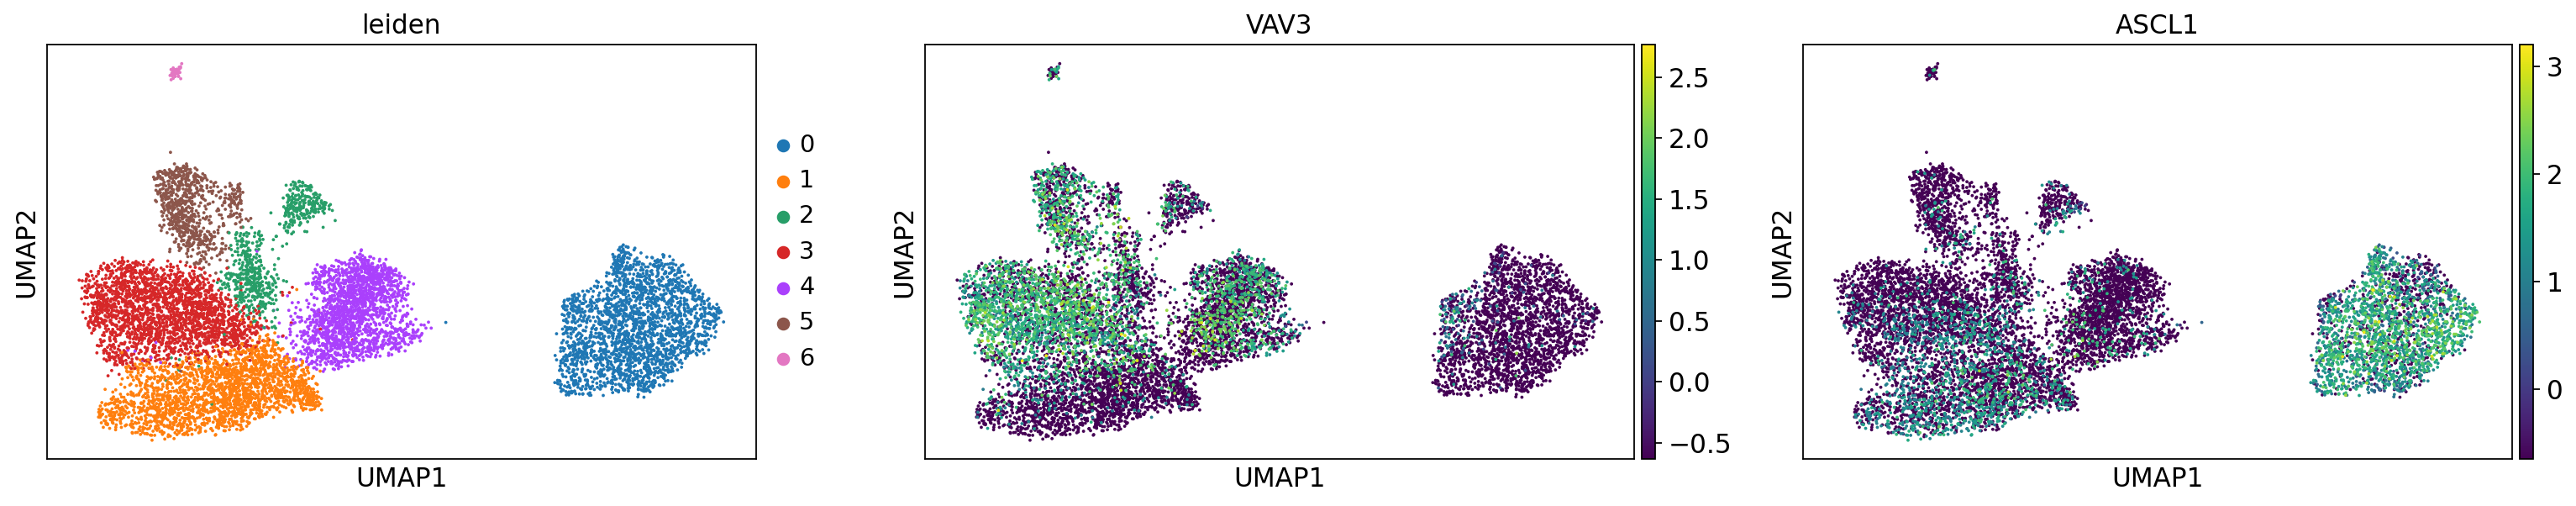

In [20]:
sc.pl.umap(adata, color=['leiden', "VAV3", "ASCL1"])

#### Identifying cluster-specific narker genes through Differential Expression Analysis

In [13]:
sc.tl.rank_genes_groups(adata, "leiden", method="logreg")
for group in adata.uns['rank_genes_groups']['names'].dtype.names:
    genes = adata.uns['rank_genes_groups']['names'][group][:25]
    print(f"Group {group}:")
    print(", ".join(genes))
    print("\n")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:03)
Group 0:
MALAT1, IRX1, NR2F2, NR2F2-AS1, EEF2, OLIG2, MEST, HES6, SERF2, ASCL1, OST4, MGST1, SOX2, COMMD6, TPT1, HBA2, OLIG1, TIMM8B, ZFAS1, CKB, ERBB4, GSTP1, TRMT112, ATRAID, NR2F1


Group 1:
MOXD1, DSCAML1, GAS1, GALNT13, TNR, DLL3, GABRB1, EMID1, DNM3, PHLDA1, CDK6, FRMD5, AFAP1L2, SERINC5, SMOC1, KCNQ1OT1, CDON, MSH6, STXBP6, CCDC178, PAK3, POU6F1, CRB1, N4BP2L1, LRRC3B


Group 2:
CCSER1, DLX6-AS1, MYT1L, LRRC7, NKAIN2, ADARB2, NRXN3, ANK3, FGF14, GRM7, RALYL, TENM2, EPHA6, MIR137HG, NELL1, RUNX1T1, KCNJ3, KCNB2, MIAT, ZNF536, FGF12, SYT1, EDIL3, HIVEP3, CNTNAP4


Group 3:
RGS6, VAV3, GALR1, PTPRT, CSGALNACT1, LHFPL3, KCNIP1, PTPRE, LGR6, SPATA6, SEMA5A, SLC4A4, IRAK2, ALDH1L1, TNC, SWAP70, KLHL4, EYA2, ELL2, FREM2, RAPGEF4, FGFR1, ABLIM1, PLEKHH2, MATN2


Group 4:
NEUROD6, STMN2, LSAMP-AS

#### I tested known marker genes on the UMAP, including one gene to identify cell-cycling cells, as one cluster appeared distinctly separated, and we hypothesized it might represent cycling pre-OPCs, which are problematic for classifiers.
**note**te: In this repeated analysis, Cluster 4 also appears to be cell-cycling. In previous analys , this was not evident. I have also removed this cluster, which we initially retained. The figures in the report refer to the version prior to the removal of Cluster 4.

In [14]:
Pre_astrocytes_markers = ["LGR6", "VAV3"]

In [15]:
Pre_OPCs_markers =["ASCL1", "DLL3", "KCNQ1OT1"]

In [26]:
cycling_markers =["TUBA1B"]

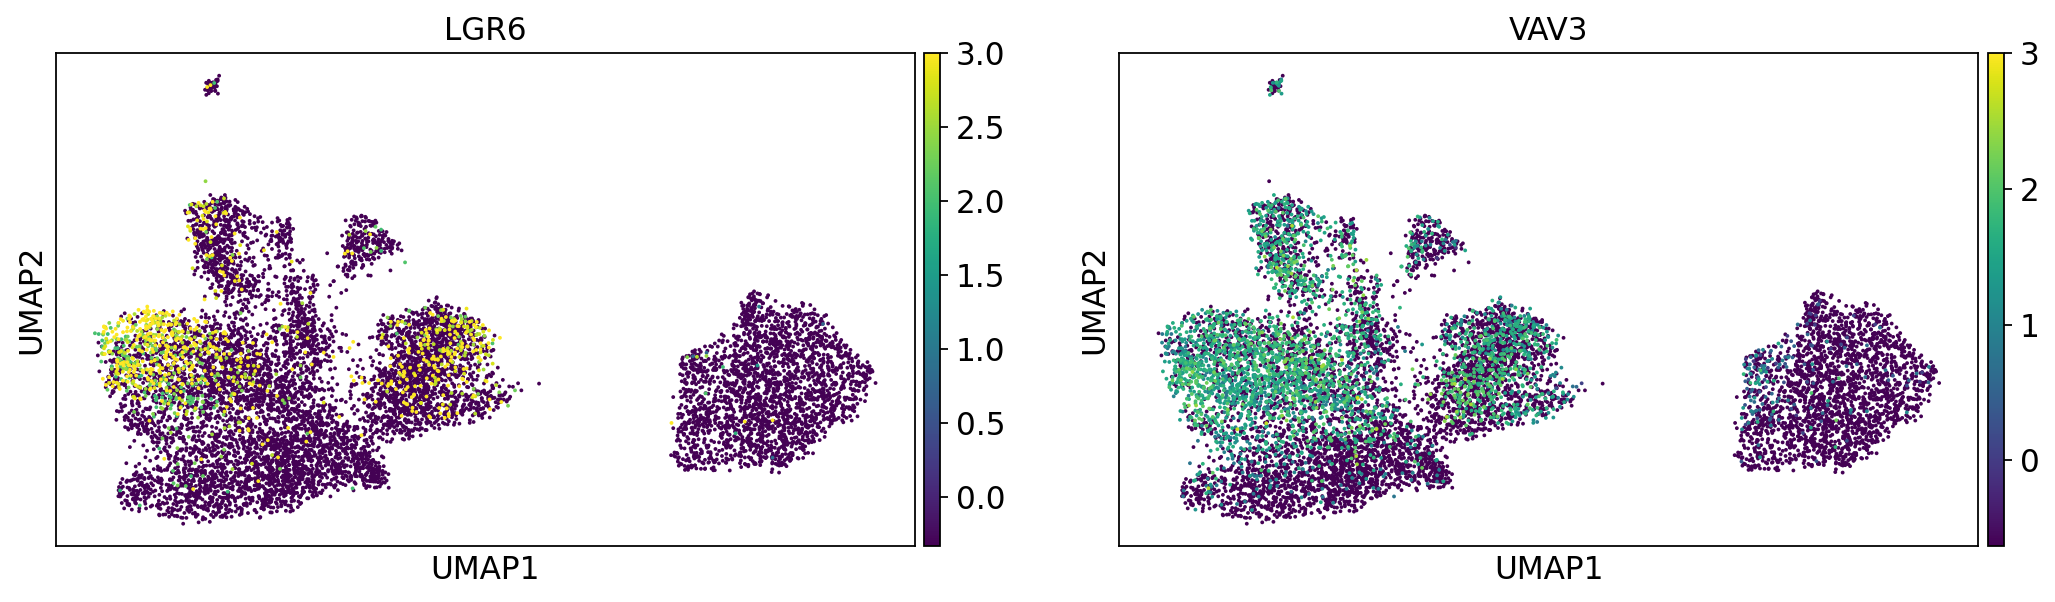

In [27]:
sc.pl.umap(adata, color=Pre_astrocytes_markers, vmax = 3)

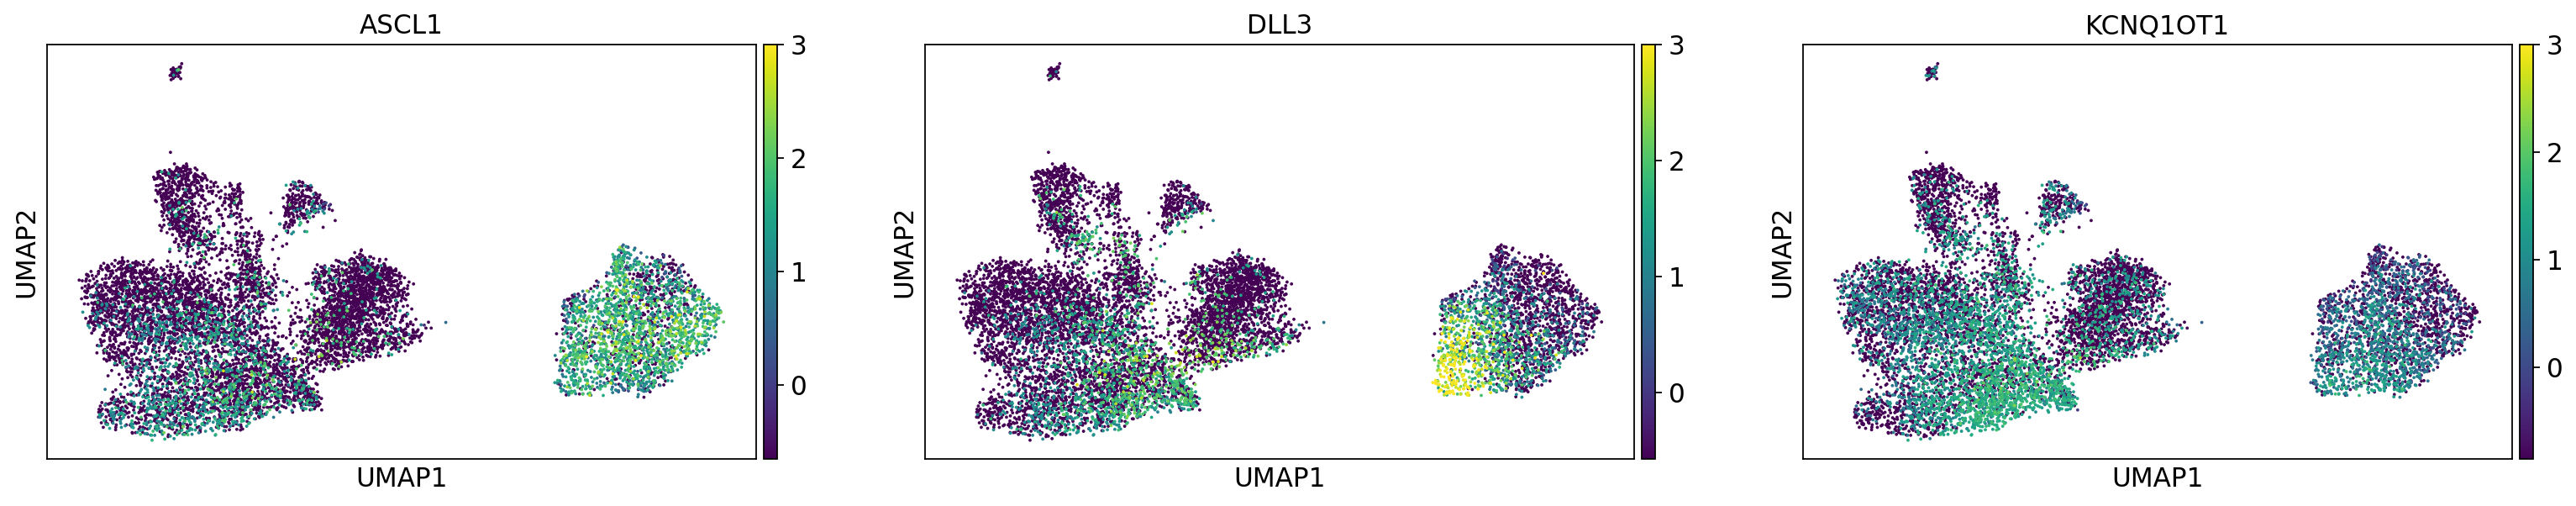

In [28]:
sc.pl.umap(adata, color=Pre_OPCs_markers, vmax = 3)

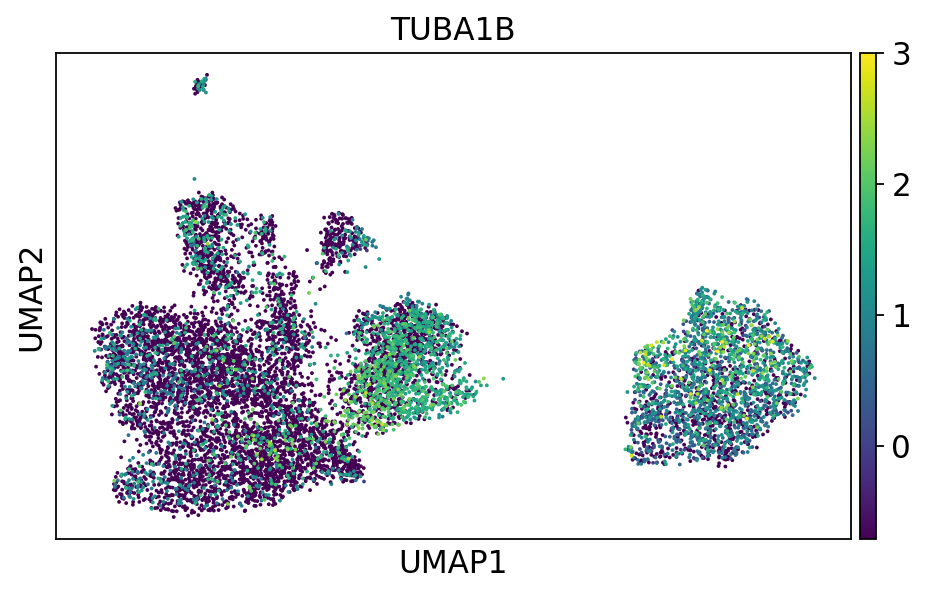

In [29]:
sc.pl.umap(adata, color=cycling_markers, vmax = 3)

#### Finally, I re-annotated the cells based on these new insights.

In [32]:
adata.obs['GIPCsDivisionReannotation'] = adata.obs['leiden'].apply(
    lambda x: 'pre-OPCs' if x == '1' else ('Cycling' if x in ['0', '4', '6'] else 'pre-Astrocytes')
)

(Run this commented cell instead of the previous one to reannotate the cells as I did for the report).

In [ ]:
#adata.obs['GIPCsDivisionReannotation'] = adata.obs['leiden'].apply(
#    lambda x: 'pre-OPCs' if x == '1' else ('Cycling' if x in ['0', '6'] else 'pre-Astrocytes')
#)

In [33]:
adata.obs['GIPCsDivisionReannotation'].value_counts()

GIPCsDivisionReannotation
Cycling           4264
pre-Astrocytes    3675
pre-OPCs          2227
Name: count, dtype: int64

In [34]:
clusters_new_palette = [  "#809776", "#ae4acd","#0064e1","#94abe1", "#7d4400", "#0cc0aa", "#b75970", "#7fdc64", "#2c647e", "#b1bf81", "#c5089e"]

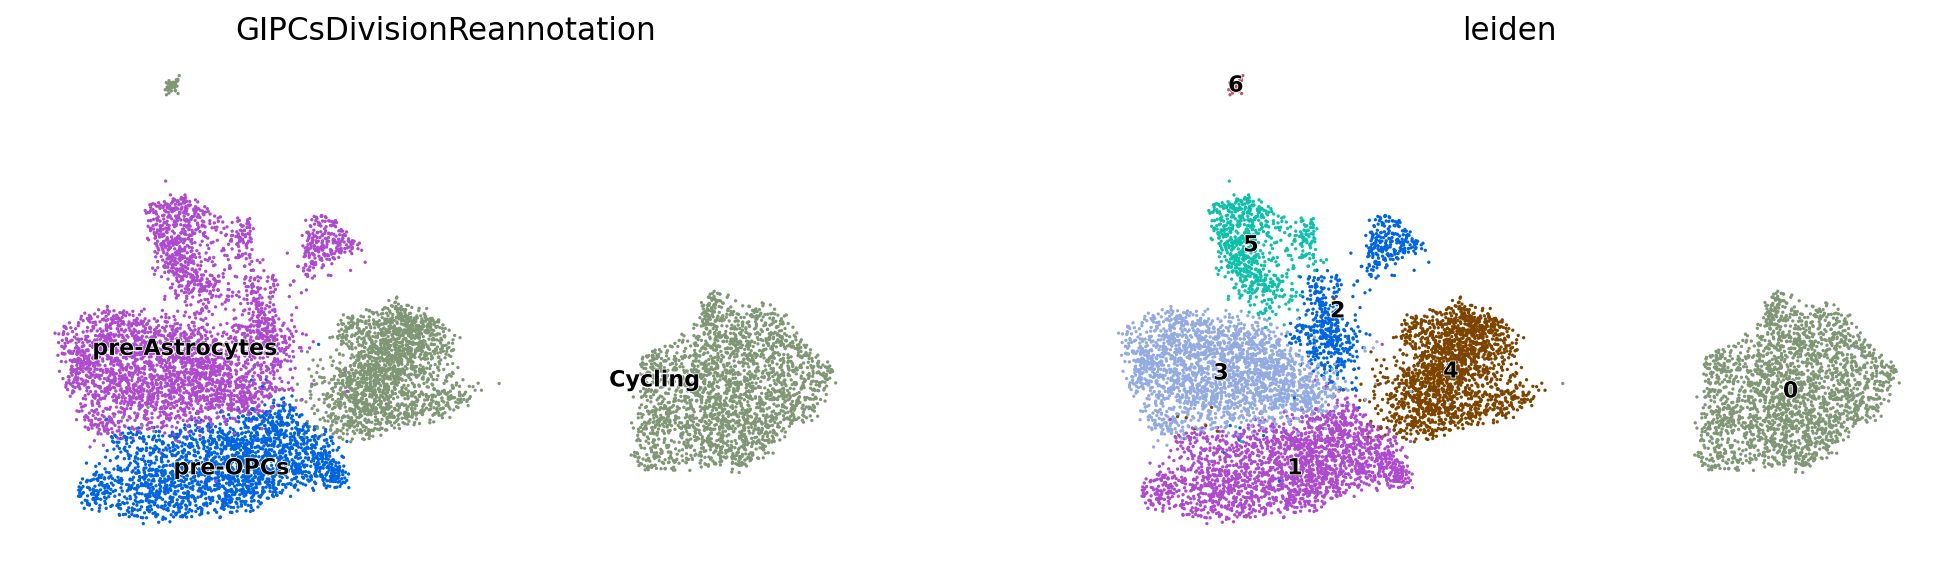

In [35]:
ax = sc.pl.embedding(
    adata,
    basis='X_umap',
    color= ['GIPCsDivisionReannotation', 'leiden'],
    palette=clusters_new_palette,
    size=9,
    legend_loc='on data',
    legend_fontsize=10,
    legend_fontoutline=0.7,
    frameon=False,
    show=False,
    return_fig=True
)


#### save the result to import it into the main notebook `from_noAdolescence_to_final_training_dataset.ipynb`

In [40]:
#adata.obs[['GIPCsDivisionReannotation']].to_csv('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/GIPCsDivisionReannotation.csv')